In [1]:
from pathlib import Path
import itertools
from matplotlib import pyplot as plt

stim_data_dir = Path("..", "data", "Nimstim faces")
grayscale = True

open_files = [x for x in stim_data_dir.glob("*_O.bmp")]
closed_files = [x for x in stim_data_dir.glob("*_C.bmp")]

#     img = open_files[0]
data_file = list(itertools.islice(open_files, 1))[0]


In [2]:
from protosc.preprocessing import GreyScale, ViolaJones, CutCircle
from protosc.io import ReadImage

In [3]:
pipe = ReadImage()*GreyScale()*ViolaJones()*CutCircle()

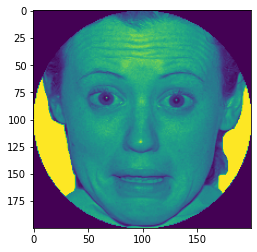

In [4]:
plt.imshow(pipe.execute(data_file, max_depth=0))
plt.show()

In [5]:
print(data_file)

../data/Nimstim faces/02F_FE_O.bmp


In [6]:
images = pipe.execute(open_files, max_depth=1)

In [7]:
for f in open_files:
    print(f)

../data/Nimstim faces/02F_FE_O.bmp
../data/Nimstim faces/01F_AN_O.bmp
../data/Nimstim faces/01F_SA_O.bmp
../data/Nimstim faces/06F_SA_O.bmp
../data/Nimstim faces/05F_AN_O.bmp
../data/Nimstim faces/03F_HA_O.bmp
../data/Nimstim faces/01F_HA_O.bmp
../data/Nimstim faces/02F_SP_O.bmp
../data/Nimstim faces/03F_AN_O.bmp
../data/Nimstim faces/01F_SP_O.bmp
../data/Nimstim faces/05F_NE_O.bmp
../data/Nimstim faces/05F_SP_O.bmp
../data/Nimstim faces/05F_CA_O.bmp
../data/Nimstim faces/06F_DI_O.bmp
../data/Nimstim faces/01F_DI_O.bmp
../data/Nimstim faces/03F_CA_O.bmp
../data/Nimstim faces/06F_HA_O.bmp
../data/Nimstim faces/03F_SP_O.bmp
../data/Nimstim faces/06F_AN_O.bmp
../data/Nimstim faces/03F_FE_O.bmp
../data/Nimstim faces/01F_NE_O.bmp
../data/Nimstim faces/05F_HA_O.bmp
../data/Nimstim faces/05F_DI_O.bmp
../data/Nimstim faces/06F_NE_O.bmp
../data/Nimstim faces/01F_FE_O.bmp
../data/Nimstim faces/03F_DI_O.bmp
../data/Nimstim faces/03F_NE_O.bmp
../data/Nimstim faces/05F_FE_O.bmp
../data/Nimstim face